# Vizualizing the known planet population

The purpose of this notebook is to produce graphics to illustrate the known planet population. 
This uses data from the [NASA Exoplanet Archives Composite Data table](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars), which should be downloaded in CSV format.

In [1]:
from os import path
import csv
from matplotlib import pyplot as plt
from astropy.table import Table, Column
from astropy import units as u 
from astropy.coordinates import SkyCoord, Galactocentric
from mw_plot import MWSkyMap, MWFaceOn
import numpy as np

# Configuration
data_dir = './data/'
mulens_data_file = 'PSCompPars_2024.12.13_14.48.01.csv'
all_data_file = 'PSCompPars_2024.12.15_21.37.29.csv'

In [2]:
def load_nexsci_data(file_path):
    """
    Function to load data on known planetary systems from the NASA Exoplanet Archive's Combined Data table.
    The file format expected is that output from the archive's website in CSV format

    Parameters
    file_path   string   Path to input CSV datafile

    Returned
    planet_data  Table   Astropy Table object with all columns of the datafile
    """
    
    # Not all of the columns are numeric data, so in order to parse these columns correctly, we identify those which necessarily have to be strings
    string_keys = ['pl_name', 'hostname', 'discoverymethod', 'disc_facility', 'rastr', 'decstr', 'sy_gaiamagerr2', 'st_spectype', 'pl_bmassprov', 'st_metratio']
    
    with open(file_path) as csvfile:    
        reader = csv.reader(csvfile, delimiter=',')
        
        # First read the column descriptors in order to build the table; then use those keys to set data columns
        # This allows us to be reasonably flexible to changes in the file format
        headers = None
        for row in reader:
            if '#' not in row[0] and not headers:
                headers = row
                data = {key: [] for key in headers}
            elif '#' not in row[0] and headers:
                for i, entry in enumerate(row):
                    key = headers[i]
                    if key in string_keys:
                        data[key].append(entry)
                    else:
                        if len(entry.replace('\n','')) > 0:
                            try:
                                data[key].append(float(entry.replace('\n','')))
                            except:
                                print(key, entry, headers[i], (headers[i] in string_keys))
                        else:
                            data[key].append(np.nan)
    
    col_list = [Column(name=key, data=arr) for key,arr in data.items()]
    planet_data = Table(col_list)
    
    return planet_data

In [3]:
file_path = path.join(data_dir, mulens_data_file)
planet_data = load_nexsci_data(file_path)
planet_data

pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassprov,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,ttv_flag,st_spectype,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_rad,st_raderr1,st_raderr2,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,st_met,st_meterr1,st_meterr2,st_metlim,st_metratio,st_logg,st_loggerr1,st_loggerr2,st_logglim,rastr,ra,decstr,dec,sy_dist,sy_disterr1,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
str24,str22,float64,float64,str12,float64,str42,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,str13,float64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10
Gaia22dkvL b,Gaia22dkvL,1.0,1.0,Microlensing,2024.0,European Space Agency (ESA) Gaia Satellite,0.0,nan,nan,nan,nan,1.4,0.77,-0.34,0.0,14.1,nan,nan,0.0,1.26,nan,nan,0.0,187.83659,48.30992,-16.52708,0.0,0.591,0.152,-0.052,0.0,Mass,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,,nan,nan,nan,nan,nan,nan,nan,nan,1.15,0.15,-0.08,0.0,nan,nan,nan,nan,,nan,nan,nan,nan,10h07m04.56s,151.769,-66d10m51.20s,-66.1808889,1270.0,430.0,-250.0,nan,nan,nan,nan,nan,nan,nan,nan,
K2-2016-BLG-0005L b,K2-2016-BLG-0005L,1.0,1.0,Microlensing,2023.0,K2,0.0,4700.0,3000.0,-700.0,0.0,4.16,0.32,-0.32,0.0,13.7,nan,nan,0.0,1.23,nan,nan,0.0,349.61125,28.60456,-28.60456,0.0,1.1,0.09,-0.09,0.0,Mass,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,,nan,nan,nan,nan,nan,nan,nan,nan,0.58,0.04,-0.04,0.0,nan,nan,nan,nan,,nan,nan,nan,nan,17h59m31.16s,269.8798333,-27d36m26.90s,-27.6074722,5200.0,240.0,-240.0,nan,nan,nan,nan,nan,nan,nan,nan,
KMT-2016-BLG-0212L b,KMT-2016-BLG-0212L,1.0,1.0,Microlensing,2018.0,KMTNet,0.0,nan,nan,nan,nan,2.2,0.7,-0.7,0.0,12.2,nan,nan,0.0,1.08,nan,nan,0.0,5700.0,6000.0,-3500.0,0.0,18.0,20.0,-11.0,0.0,Mass,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,,nan,nan,nan,nan,nan,nan,nan,nan,0.48,0.38,-0.26,0.0,nan,nan,nan,nan,,nan,nan,nan,nan,17h53m45.42s,268.43925,-29d05m12.80s,-29.0868889,6300.0,1100.0,-1600.0,nan,nan,nan,nan,nan,nan,nan,nan,
KMT-2016-BLG-1105L b,KMT-2016-BLG-1105L,1.0,1.0,Microlensing,2023.0,KMTNet,0.0,nan,nan,nan,nan,2.44,0.88,-0.75,0.0,1.33,nan,nan,0.0,0.118,nan,nan,0.0,2.32,7.43,-1.56,0.0,0.0073,0.02338,-0.00491,0.0,Mass,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,,nan,nan,nan,nan,nan,nan,nan,nan,0.41,0.25,-0.21,0.0,nan,nan,nan,nan,,nan,nan,nan,nan,17h45m47.34s,266.44725,-26d15m58.93s,-26.2663694,5080.0,2240.0,-2180.0,nan,nan,nan,nan,nan,nan,nan,nan,
KMT-2016-BLG-1107L b,KMT-2016-BLG-1107L,1.0,1.0,Microlensing,2019.0,KMTNet,0.0,nan,nan,nan,nan,0.342,0.07,-0.085,0.0,13.1,nan,nan,0.0,1.17,nan,nan,0.0,1043.0,1102.0,-583.0,0.0,3.283,3.468,-1.835,0.0,Mass,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,,nan,nan,nan,nan,nan,nan,nan,nan,0.09,0.09,-0.05,0.0,nan,nan,nan,nan,,nan,nan,nan,nan,17h45m40.26s,266.41775,-26d01m54.48s,-26.0318,6651.0,948.0,-1348.0,nan,nan,nan,nan,nan,nan,nan,nan,
KMT-2016-BLG-1397L b,KMT-2016-BLG-1397L,1.0,1.0,Microlensing,2018.0,KMTNet,0.0,nan,nan,nan,nan,5.1,1.5,-1.7,0.0,12.7,nan,nan,0.0,1.13,nan,nan,0.0,2200.0,1700.0,-1400.0,0

## Visualizing the locations of planets detected by microlensing

Using the data from the archive, we can calculate the galactic coordinates of all planet systems detected by microlensing in order to plot them with respect to the Galaxy

In [4]:
planet_coords = SkyCoord(
    ra=planet_data['ra']*u.deg, 
    dec=planet_data['dec']*u.deg,
    distance=planet_data['sy_dist']*u.pc,
    frame='icrs'
)
#planet_coords = planet_coords.transform_to('galactic')

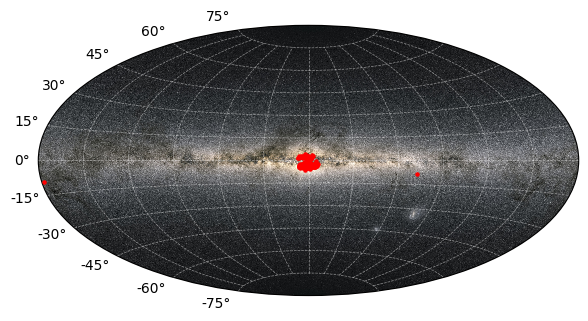

In [5]:
mw1 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic')
mw1.scatter(planet_coords.ra.deg*u.deg, planet_coords.dec.deg*u.deg, c="r", s=5)
plt.tight_layout()
plt.savefig(path.join(data_dir, 'mulens_planet_sky_map.png'))

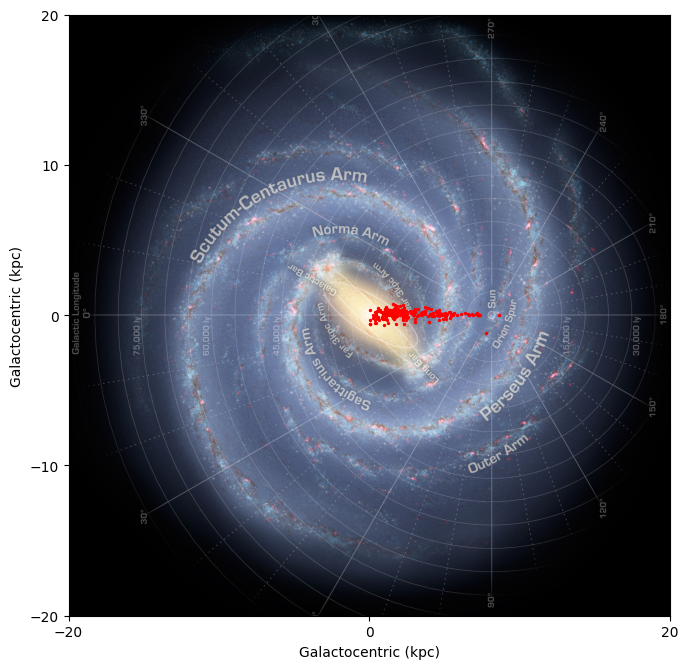

In [6]:
mw2 = MWFaceOn(
    radius=20 * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    annotation=True,
    figsize=(10, 8),
)

gc = planet_coords.transform_to(Galactocentric)

mw2.scatter(abs(gc.x), gc.y, c="r", s=2)
plt.rcParams.update({'font.size': 50})
plt.tight_layout()
plt.savefig(path.join(data_dir, 'mulens_planet_galaxy.png'))

## Mass - semi-major axis parameter space

A key parameter space to explore is how the planets are distributed in mass and semi-major axis from their host star, bearing in mind that this is usually projected semi-major axis for microlensing detections.

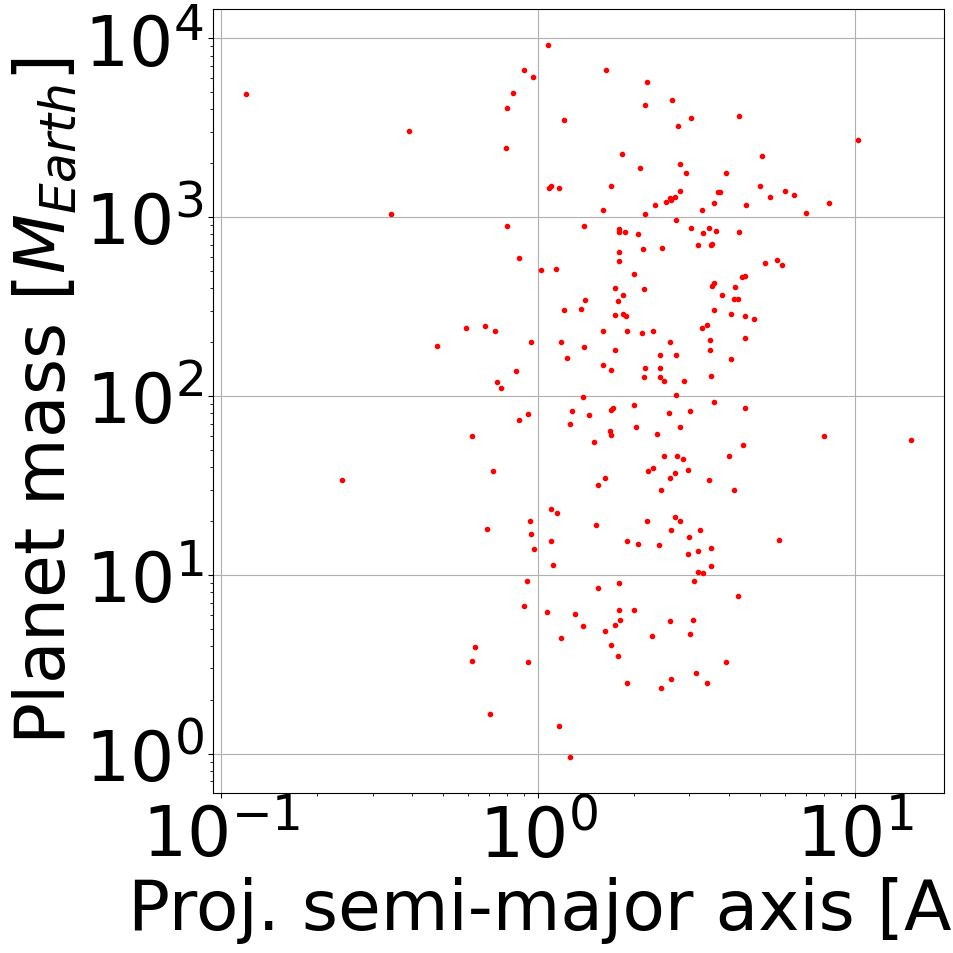

In [7]:
fig = plt.figure(3, (10,10))

# Columns pl_bmasse = Planet Mass or Mass*sin(i) [Earth Mass], pl_orbsmax:     Orbit Semi-Major Axis [au]
plt.plot(planet_data['pl_orbsmax'], planet_data['pl_bmasse'], 'r.')
plt.rcParams.update({'font.size': 22})
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.xlabel('Proj. semi-major axis [AU]')
plt.ylabel('Planet mass [$M_{Earth}$]')
plt.grid()
plt.tight_layout()
plt.savefig(path.join(data_dir, 'mulens_planet_m_vs_a.png'))

## Planets from different detection techniques

In [8]:
file_path = path.join(data_dir, all_data_file)
all_planet_data = load_nexsci_data(file_path)
all_planet_data

pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassprov,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,ttv_flag,st_spectype,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_rad,st_raderr1,st_raderr2,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,st_met,st_meterr1,st_meterr2,st_metlim,st_metratio,st_logg,st_loggerr1,st_loggerr2,st_logglim,rastr,ra,decstr,dec,sy_dist,sy_disterr1,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
str29,str27,float64,float64,str29,float64,str46,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,str14,float64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10
11 Com b,11 Com,2.0,1.0,Radial Velocity,2007.0,Xinglong Station,0.0,323.21,0.06,-0.05,0.0,1.178,0.0,0.0,0.0,12.2,nan,nan,0.0,1.09,nan,nan,0.0,4914.89849,39.09289,-39.72855,0.0,15.464,0.123,-0.125,0.0,Msini,0.238,0.007,-0.007,0.0,nan,nan,nan,nan,nan,nan,nan,nan,0.0,G8 III,4874.0,nan,nan,0.0,13.76,2.85,-2.45,0.0,2.09,0.64,-0.63,0.0,-0.26,0.1,-0.1,0.0,[Fe/H],2.45,0.08,-0.08,0.0,12h20m42.91s,185.1787793,+17d47m35.71s,17.7932516,93.1846,1.9238,-1.9238,4.72307,0.023,-0.023,2.282,0.346,-0.346,4.44038,0.0038479,-0.0038479
11 UMi b,11 UMi,1.0,1.0,Radial Velocity,2009.0,Thueringer Landessternwarte Tautenburg,0.0,516.21997,3.2,-3.2,0.0,1.53,0.07,-0.07,0.0,12.3,nan,nan,0.0,1.09,nan,nan,0.0,4684.8142,794.575,-794.575,0.0,14.74,2.5,-2.5,0.0,Msini,0.08,0.03,-0.03,0.0,nan,nan,nan,nan,nan,nan,nan,nan,0.0,K4 III,4213.0,46.0,-46.0,0.0,29.79,2.84,-2.84,0.0,2.78,0.69,-0.69,0.0,-0.02,nan,nan,0.0,[Fe/H],1.93,0.07,-0.07,0.0,15h17m05.90s,229.2745954,+71d49m26.19s,71.8239428,125.321,1.9765,-1.9765,5.013,0.005,-0.005,1.939,0.27,-0.27,4.56216,0.0039035,-0.0039035
14 And b,14 And,1.0,1.0,Radial Velocity,2008.0,Okayama Astrophysical Observatory,0.0,186.76,0.11,-0.12,0.0,0.775,0.0,0.0,0.0,13.1,nan,nan,0.0,1.16,nan,nan,0.0,1131.1513,36.23244,-38.77507,0.0,3.559,0.114,-0.122,0.0,Msini,0.0,nan,nan,0.0,nan,nan,nan,nan,nan,nan,nan,nan,0.0,K0 III,4888.0,nan,nan,0.0,11.55,1.12,-0.51,0.0,1.78,0.43,-0.29,0.0,-0.21,0.1,-0.1,0.0,[Fe/H],2.55,0.06,-0.07,0.0,23h31m17.80s,352.82415,+39d14m09.01s,39.2358367,75.4392,0.714,-0.714,5.23133,0.023,-0.023,2.331,0.24,-0.24,4.91781,0.0028262,-0.0028262
14 Her b,14 Her,1.0,2.0,Radial Velocity,2002.0,W. M. Keck Observatory,0.0,1765.0389,1.67709,-1.87256,0.0,2.774,0.109,-0.12,0.0,12.6,nan,nan,0.0,1.12,nan,nan,0.0,2559.47216,518.69596,-280.64248,0.0,8.053,1.632,-0.883,0.0,Mass,0.373,0.008,-0.006,0.0,nan,nan,nan,nan,nan,nan,nan,nan,0.0,K0 V,5338.0,25.0,-25.0,0.0,0.93,0.01,-0.01,0.0,0.91,0.11,-0.11,0.0,0.405,0.047,-0.047,0.0,[Fe/H],4.45,0.02,-0.02,0.0,16h10m24.50s,242.6021014,+43d48m58.90s,43.8163621,17.9323,0.0073,-0.0073,6.61935,0.023,-0.023,4.714,0.016,-0.016,6.383,0.0003512,-0.0003512
16 Cyg B b,16 Cyg B,3.0,1.0,Radial Velocity,1996.0,Multiple Observatories,0.0,798.5,1.0,-1.0,0.0,1.66,0.03,-0.03,0.0,13.5,nan,nan,0.0,1.2,nan,nan,0.0,565.7374,25.4264,-25.4264,0.0,1.78,0.08,-0.08,0.0,Msini,0.68,0.02,-0.02,0.0,nan,nan,nan,nan,nan,nan,nan,nan,0.0,G3 V,5750.0,8.0,-8.0,0.0,1.13,0.01

In [15]:
unique_methods = []
[unique_methods.append(x) for x in all_planet_data['discoverymethod'].data.tolist() if x not in unique_methods]
unique_methods

['Radial Velocity',
 'Imaging',
 'Eclipse Timing Variations',
 'Transit',
 'Transit Timing Variations',
 'Astrometry',
 'Microlensing',
 'Disk Kinematics',
 'Orbital Brightness Modulation',
 'Pulsation Timing Variations',
 'Pulsar Timing']

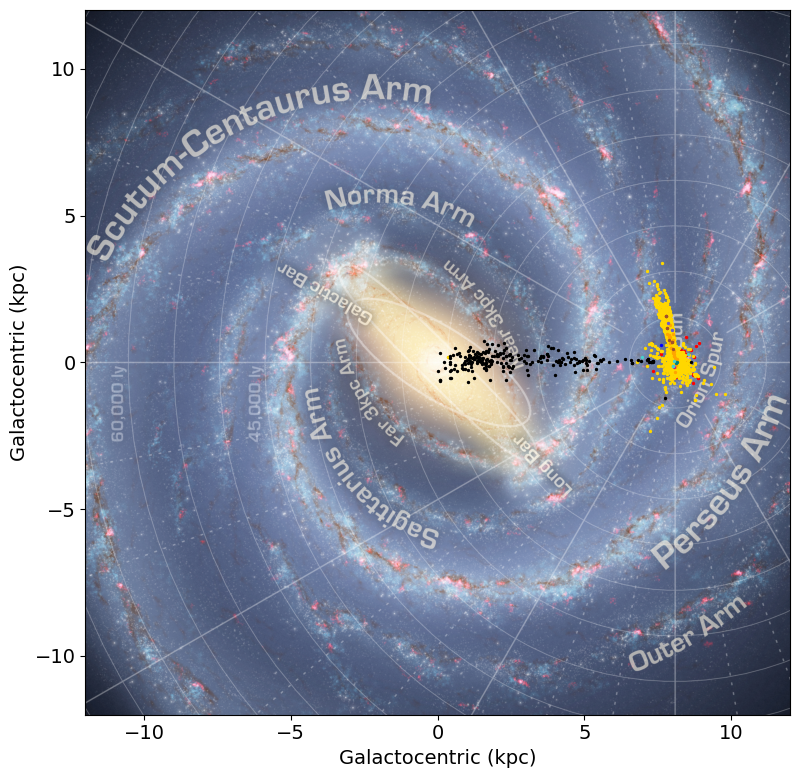

In [23]:
# Plot the Milky Way face on and chart where different techniques have found different planet populations
mw2 = MWFaceOn(
    radius=12 * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    annotation=True,
    figsize=(10, 8),
)

symbols = {
    'Radial Velocity': 'o',
    'Imaging': 's',
    'Eclipse Timing Variations': 'v',
     'Transit': '^',
     'Transit Timing Variations': '<',
     'Astrometry': '*',
     'Microlensing': 'h',
     'Disk Kinematics': 'p',
     'Orbital Brightness Modulation': '>',
     'Pulsation Timing Variations': 'X',
     'Pulsar Timing': 'P'
}
colors = {
    'Radial Velocity': 'r',
    'Imaging': 'g',
    'Eclipse Timing Variations': 'b',
     'Transit': 'gold',
     'Transit Timing Variations': 'orange',
     'Astrometry': 'teal',
     'Microlensing': 'k',
     'Disk Kinematics': 'mediumvioletred',
     'Orbital Brightness Modulation': 'sienna',
     'Pulsation Timing Variations': 'slateblue',
     'Pulsar Timing': 'mediumturquoise'
}

for method in unique_methods:
    # Extract the coordinates of the planet systems detected by this method
    jdx = (all_planet_data['discoverymethod'] == method)
    planet_coords = SkyCoord(
        ra=all_planet_data['ra'][jdx]*u.deg, 
        dec=all_planet_data['dec'][jdx]*u.deg,
        distance=all_planet_data['sy_dist'][jdx]*u.pc,
        frame='icrs'
    )
    gc = planet_coords.transform_to(Galactocentric)

    # Symbol?
    mw2.scatter(abs(gc.x), gc.y, c=colors[method], s=2)
    
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig(path.join(data_dir, 'all_planets_all_methods_galaxy.png'))
#plt.show()